In [1]:

import math
import stackstac # type: ignore
import planetary_computer # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from dask.diagnostics import ProgressBar # type: ignore
from dask.array import nanmedian # type: ignore

from pystac_client import Client # type: ignore

from dask.distributed import Client as DaskClient # type: ignore

client = DaskClient()  # Start Dask client with default settings
client

<Client: 'tcp://127.0.0.1:59289' processes=4 threads=12, memory=32.00 GiB>

In [2]:
# Access the Planetary Computer's STAC API
stac_api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
client = Client.open(stac_api_url)

# Search for Sentinel-2 imagery
search = client.search(
    collections=["sentinel-2-l2a"],
    bbox=[-106.5, 35.0, -106.4, 35.1],  
    datetime="2023-01-01/2023-12-31",  
    query={"eo:cloud_cover": {"lt": 20}},  # Filter by cloud cover
)

# Get the items from the search
items = search.item_collection()

# Sign the items for authenticated access
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

# Stackstac to read the imagery into an xarray DataArray
datacube = stackstac.stack(
    signed_items,
    assets=["B04", "B08"],  # Red and NIR bands for NDVI
    resolution=30,
    dtype=np.float64,
    bounds_latlon=(-106.5, 35.0, -106.4, 35.1), 
    epsg=3857,
    rescale=False  
)

# Use labeled dimensions
datacube = datacube.rename(band="band", x="longitude", y="latitude", time="time")
datacube 


<xarray.DataArray 'stackstac-a1ce731697d5976ef145ff7308115d3b' (time: 96,
                                                                band: 2,
                                                                latitude: 454,
                                                                longitude: 372)> Size: 259MB
dask.array<fetch_raster_window, shape=(96, 2, 454, 372), dtype=float64, chunksize=(1, 1, 454, 372), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 768B 2023-...
    id                                       (time) <U54 21kB 'S2B_MSIL2A_202...
  * band                                     (band) <U3 24B 'B04' 'B08'
  * longitude                                (longitude) float64 3kB -1.186e+...
  * latitude                                 (latitude) float64 4kB 4.178e+06...
    s2:thin_cirrus_percentage                (time) float64 768B 1.188 ... 0....
    ...                                       ...
    gsd                                      float64 8B 10.0
    proj:transform                           object 8B {0.0, 3900000.0, 30000...
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-11855550, 4163880, -11844390,...
    crs:         epsg:3857
    transform:   | 30.00, 0.00,-11855550.00|\n| 0.00,-30.00, 4177500.00|\n| 0...
    resolution:  30

In [3]:
# Group data by month and calculate the median for each month
# Convert time to "month" granularity
datacube = datacube.resample(time="1ME").reduce(nanmedian)
datacube

<xarray.DataArray 'stackstac-a1ce731697d5976ef145ff7308115d3b' (time: 12,
                                                                band: 2,
                                                                latitude: 454,
                                                                longitude: 372)> Size: 32MB
dask.array<stack, shape=(12, 2, 454, 372), dtype=float64, chunksize=(1, 2, 454, 372), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * band                                     (band) <U3 24B 'B04' 'B08'
  * longitude                                (longitude) float64 3kB -1.186e+...
  * latitude                                 (latitude) float64 4kB 4.178e+06...
    proj:epsg                                int64 8B 32613
    instruments                              <U3 12B 'msi'
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    proj:transform                           object 8B {0.0, 3900000.0, 30000...
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 3857
  * time                                     (time) datetime64[ns] 96B 2023-0...
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-11855550, 4163880, -11844390,...
    crs:         epsg:3857
    transform:   | 30.00, 0.00,-11855550.00|\n| 0.00,-30.00, 4177500.00|\n| 0...
    resolution:  30

In [4]:
# Select the NIR (B08) and Red (B04) bands
nir = datacube.sel(band="B08")
red = datacube.sel(band="B04")

# NDVI Calculation
ndvi = (nir - red) / (nir + red)

# Enable Dask to use multiple cores for computation
ndvi = ndvi.chunk({"time": 1, "latitude": 100, "longitude": 100})

# Compute NDVI across the time series using Dask's parallelism
with ProgressBar():
    ndvi = ndvi.compute()    

In [5]:
ndvi

<xarray.DataArray 'stackstac-a1ce731697d5976ef145ff7308115d3b' (time: 12,
                                                                latitude: 454,
                                                                longitude: 372)> Size: 16MB
array([[[0.09504042, 0.1275351 , 0.0569697 , ..., 0.25348896,
         0.26790185, 0.2030232 ],
        [0.16782027, 0.10611545, 0.05385962, ..., 0.26273016,
         0.24478842, 0.23962145],
        [0.09790832, 0.14771242, 0.07423935, ..., 0.22395769,
         0.22741117, 0.25958517],
        ...,
        [0.03888984, 0.04824486, 0.04863379, ..., 0.18201754,
         0.18348032, 0.16234922],
        [0.06683067, 0.05896849, 0.07422792, ..., 0.19278841,
         0.16237497, 0.13215521],
        [0.05498095, 0.05442429, 0.06165813, ..., 0.1749246 ,
         0.16551444, 0.10707529]],

       [[0.09814324, 0.10163934, 0.05682183, ..., 0.24498416,
         0.27595201, 0.19782609],
        [0.18459607, 0.10809793, 0.04848046, ..., 0.27002967,
         0.24428274, 0.25402597],
        [0.09550321, 0.14051435, 0.12193252, ..., 0.21632653,
         0.23260644, 0.26021833],
...
        [0.06783023, 0.06181534, 0.09541698, ..., 0.20351024,
         0.17393043, 0.1600454 ],
        [0.05612722, 0.05255311, 0.05492852, ..., 0.19785177,
         0.17073171, 0.1430706 ],
        [0.05444785, 0.05065234, 0.04877097, ..., 0.19850808,
         0.15621348, 0.12467043]],

       [[0.09022222, 0.1193907 , 0.05066854, ..., 0.23052319,
         0.2617849 , 0.1984527 ],
        [0.15075885, 0.08127854, 0.04367905, ..., 0.23447637,
         0.22754696, 0.24083709],
        [0.10191226, 0.17028294, 0.09840637, ..., 0.23761698,
         0.20237429, 0.25245679],
        ...,
        [0.03079555, 0.04461046, 0.05902192, ..., 0.21432435,
         0.2177344 , 0.1728419 ],
        [0.05494966, 0.04702529, 0.05007474, ..., 0.22852727,
         0.18864843, 0.14774256],
        [0.04252917, 0.04369781, 0.03467517, ..., 0.19932289,
         0.15406389, 0.13158893]]])
Coordinates: (12/16)
  * longitude                                (longitude) float64 3kB -1.186e+...
  * latitude                                 (latitude) float64 4kB 4.178e+06...
    proj:epsg                                int64 8B 32613
    instruments                              <U3 12B 'msi'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    ...                                       ...
    proj:bbox                                object 8B {300000.0, 3790200.0, ...
    proj:shape                               object 8B {10980}
    gsd                                      float64 8B 10.0
    proj:transform                           object 8B {0.0, 3900000.0, 30000...
    epsg                                     int64 8B 3857
  * time                                     (time) datetime64[ns] 96B 2023-0...

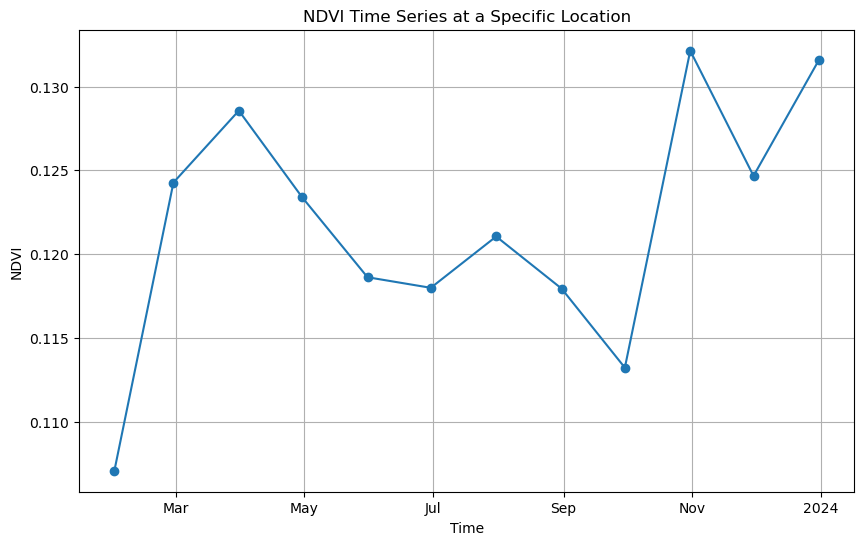

In [6]:
# Pick a specific point (latitude, longitude)
lat_point, lon_point = 35.05, -106.45

# Extract the NDVI values at the specific point over time
ndvi_timeseries = ndvi.sel(latitude=lat_point, longitude=lon_point, method="nearest")

# Plot the time series
plt.figure(figsize=(10, 6))
ndvi_timeseries.plot.line(marker="o")
plt.title("NDVI Time Series at a Specific Location")
plt.ylabel("NDVI")
plt.xlabel("Time")
plt.grid()
plt.show()


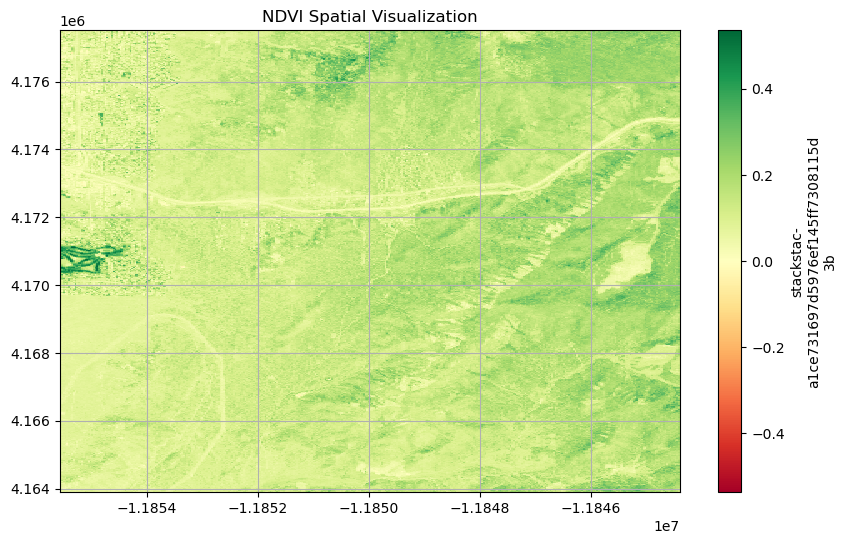

In [7]:
# Select a specific time (e.g., the first time step)
ndvi_single_time = ndvi.isel(time=0)

# Plot NDVI spatially for this time step
plt.figure(figsize=(10, 6))
ndvi_single_time.plot(cmap="RdYlGn")
plt.title("NDVI Spatial Visualization")
plt.xlabel("")
plt.ylabel("")
plt.grid()
plt.show()


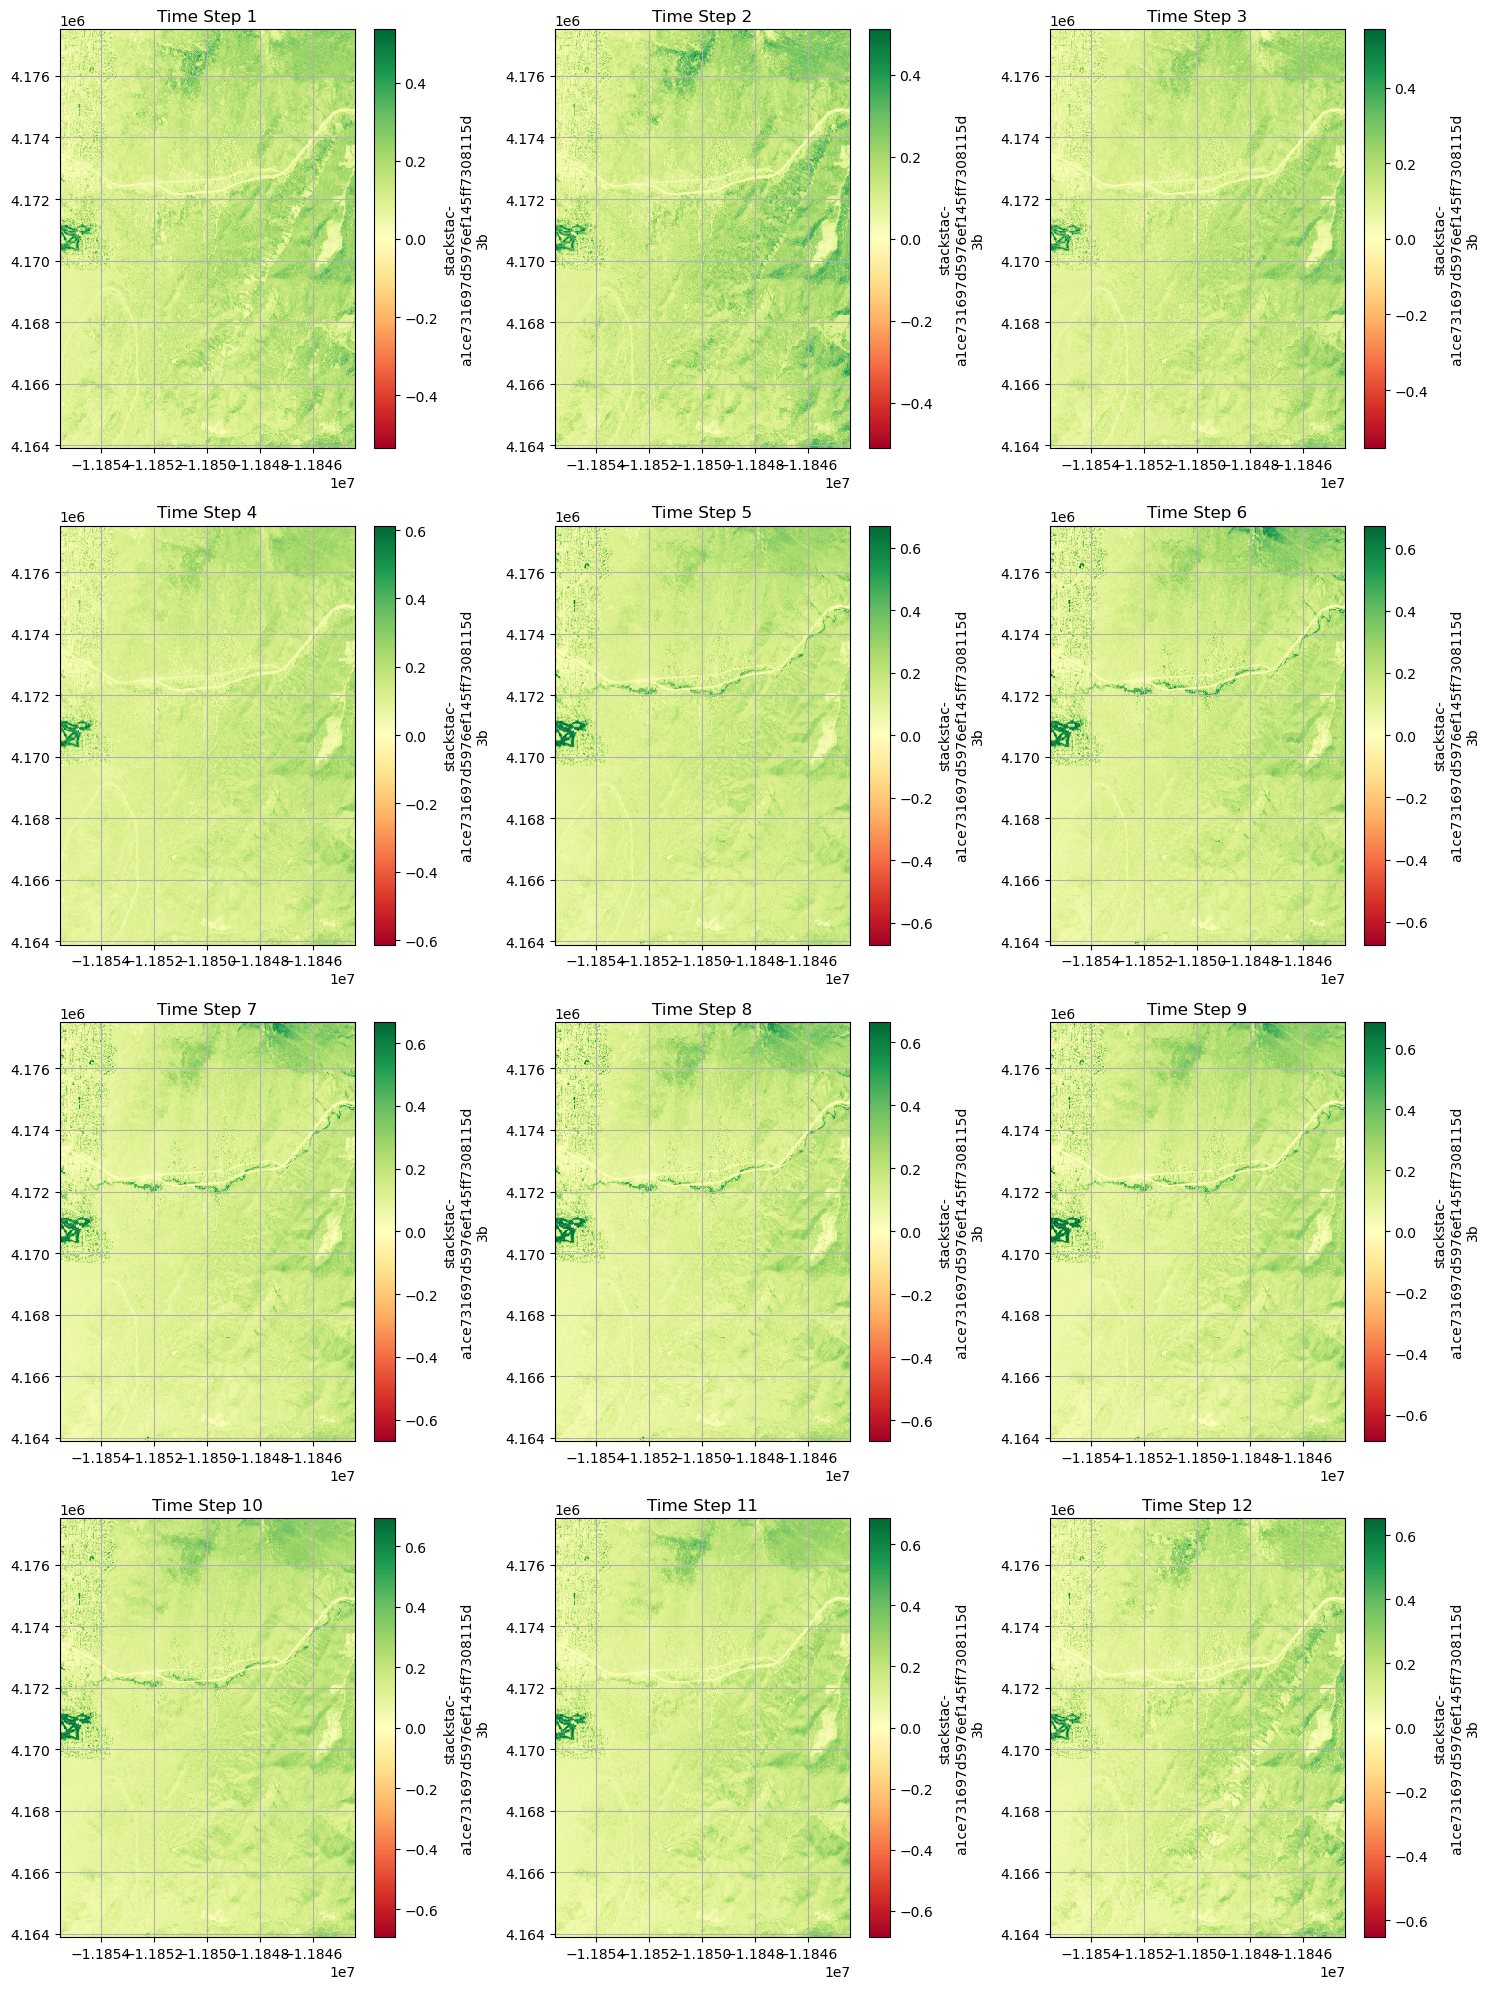

In [8]:
# Get the number of time steps
n_time_steps = ndvi.sizes['time']

# Define the number of rows and columns for the subplots (adjust based on your preference)
n_cols = 3  # Number of columns
n_rows = math.ceil(n_time_steps / n_cols)  # Calculate number of rows based on total time steps

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration (if needed for multiple rows)
axes = axes.ravel()

# Loop through each time step and plot in the respective subplot
for i in range(n_time_steps):
    # Select the NDVI for the i-th time step
    ndvi_single_time = ndvi.isel(time=i)
    
    # Plot NDVI for the current time step on the appropriate subplot axis
    ndvi_single_time.plot(ax=axes[i], cmap="RdYlGn")
    
    # Set the title for each subplot
    axes[i].set_title(f"Time Step {i+1}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].grid()

# Hide any unused subplots if the number of time steps isn't a perfect multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the figure with all time steps plotted
plt.show()
